# discounted cash flow analysis 

### Overview
    
\- Introduction to Refinitiv Company Fundamentals (RCF) & Estimates Dataset

\- Conduct Discounted Cashflow (DCF) type instrinsic valuation

\- Scale to calculate DCF for peers to provide a relative value overlay

\- Use unsupervised ML routines to generate classification groupings for our data

In [1]:
import refinitiv.dataplatform.eikon as ek
import numpy as np
import numpy_financial as npf
from numpy import where
from numpy import unique
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from ipywidgets import Box, Label, Layout
import matplotlib as plt
import warnings

%matplotlib inline
plt.style.use("seaborn")
warnings.filterwarnings("ignore")
ek.set_app_key('DEFAULT_CODE_BOOK_APP_KEY') # or just put your appkey in here

### estimates

In [3]:
df_estimates,err = ek.get_data('LSEG.L',['TR.GuidanceDate','TR.GuidanceMeasure','TR.EstGuidHighValue','TR.EstGuidLowValue','TR.GuidanceText','TR.GuidanceDocType'],
                   {'Period':'FY1','GuidMeasure':'REV,EBIT,EBITDA','GuidDataBasis':'VAL'})
 
df_estimates

,Instrument,Activation Date,Guidance Measure,Guidance High Value,Guidance Low Value,Guidance Text,The Doc Type
0,LSEG.L,2023-04-27T08:30:00Z,EBITDA,8022240000,7873680000,We're confident in our prospects for the rest ...,Transcript
1,LSEG.L,2023-04-27T08:30:00Z,Revenue,3850675200,3779366400,"And with time actually, those investments will...",Transcript
2,LSEG.L,2023-04-27T10:35:19Z,Revenue,<NA>,<NA>,We recently raised our targets for revenue syn...,Press Release
3,LSEG.L,2023-04-27T07:00:06Z,EBITDA,<NA>,<NA>,"(excl. recoveries), EBITDA margin c. 48%, busi...",Press Release
4,LSEG.L,2022-08-05T09:00:00Z,EBIT,<NA>,<NA>,"And as I look forward to 2023, I'm not going t...",Transcript
5,LSEG.L,2022-03-03T09:00:00Z,EBITDA,<NA>,<NA>,There's good profitability across all of our b...,Transcript
6,LSEG.L,2022-12-12T09:30:00Z,EBITDA,<NA>,<NA>,"And in terms of cost, excluding the investment...",Transcript


In [4]:
df4, err =ek.get_data(['LSEG.L'],['TR.RevenueEstValue(Period=FY1).date',
                                 'TR.RevenueEstValue(Period=FY1).brokername',
                                 'TR.RevenueEstValue(Period=FY1).analystname',
                                 'TR.RevenueEstValue(Period=FY1).analystcode',
                                 'TR.RevenueEstValue(Period=FY1)'])
                      
df4

,Instrument,Date,Broker Name,Analyst Name,Analyst Code,Revenue - Broker Estimate
0,LSEG.L,2023-04-28T04:10:00Z,CREDIT SUISSE - EUROPE,"Tam, Haley A",7UND,8442549000
1,LSEG.L,2023-04-27T14:46:00Z,Permission Denied 392,Permission Denied,,8315000000
2,LSEG.L,2023-04-27T17:39:00Z,Permission Denied 36928,Permission Denied,,7954000000
3,LSEG.L,2023-04-27T07:35:00Z,Permission Denied 73704,Permission Denied,,8420733000
4,LSEG.L,2023-04-28T06:27:00Z,BERENBERG,"Richardson, Peter G",771N,8036000000
5,LSEG.L,2023-05-01T05:31:00Z,Permission Denied 25632,Permission Denied,,8041643000
6,LSEG.L,2022-03-04T10:36:00Z,"MORNINGSTAR, INC.","Kammer, Niklas",7CDV,8093000000
7,LSEG.L,2023-04-28T03:05:00Z,Permission Denied 36576,Permission Denied,,8009000000
8,LSEG.L,2023-05-17T08:25:00Z,Permission Denied 32,Permission Denied,,8288200000
9,LSEG.L,2023-05-11T00:50:00Z,Permission Denied 1120,Permission Denied,,8142000000


### Consensus Estimates

\- With so many different analyst opinions - consensus estimates developed to capture mean of all analysts

\- Our I/B/E/S (Institutional Brokers Estimates System) is the industry standard, founded in 1976

\- Offers coverage for 22K active companies across 90 countries from over 18K analysts

\- Not all analysts report on all measures - so number of included estimates can vary across measure

\- Some estimates are not included due to staleness

\- Can check variation estimates are by looking at Estimate High, Low and Median

\- Great thing is we can track these consensus estimates on a daily basis 

\- Clustering / herd behaviour - can change these metrics rapidly in some cases in other cases its slow

\- To see the impact on shareprice of VOD.L - it is easy just to add a closing shareprice for the last 2000 days.

In [8]:
df6, err =ek.get_data(['LSEG.L'],['TR.RevenueMean(Period=FY1).calcdate',
                                 'TR.RevenueMean(Period=FY1)',
                                 'TR.RevenueNumIncEstimates(Period=FY1)',
                                 'TR.GrossIncomeMean(Period=FY1)',
                                 'TR.GrossIncomeNumIncEstimates(Period=FY1)',
                                 'TR.PreTaxProfitMean(Period=FY1)',
                                 'TR.PreTaxProfitNumIncEstimates(Period=FY1)',
                                 'TR.NetProfitMean(Period=FY1)',
                                 'TR.NetProfitNumIncEstimates(Period=FY1)',
                                 'TR.EPSMean(Period=FY1)',
                                 'TR.EPSNumIncEstimates(Period=FY1)',
                                 'TR.DPSMean(Period=FY1)',
                                 'TR.DPSNumIncEstimates(Period=FY1)',
                                 'TR.CLOSEPRICE(Adjusted=1)'],
                                 {'SDate':'-50','EDate':'0', 'Frq':'D'})
                      
df6.index = pd.to_datetime(df6['Calc Date'])
df6

,Instrument,Calc Date,Revenue - Mean,Revenue - Number of Included Estimates,Gross Income - Mean,Gross Income - Number of Included Estimates,Pre-Tax Profit - Mean,Pre-Tax Profit - Number of Included Estimates,Net Income - Mean,Net Income - Number of Included Estimates,Earnings Per Share - Mean,Earnings Per Share - Number of Included Estimates,Dividend Per Share - Mean,Dividend Per Share - Number of Included Estimates,Close Price
Calc Date,,,,,,,,,,,,,,,
2023-03-02,LSEG.L,2023-03-02,8041930500,8,7154000000,5,2826076250,8,1885226460,13,3.415357,12,1.135344,14,7424
2023-03-03,LSEG.L,2023-03-03,8019372000,7,7154333330,6,2817076250,8,1885441850,13,3.415948,12,1.141973,14,7568
2023-03-06,LSEG.L,2023-03-06,8045086290,7,7181166670,6,2817076250,8,1884826460,13,3.413282,12,1.141973,14,7484
2023-03-07,LSEG.L,2023-03-07,8045086290,7,7181166670,6,2820390000,8,1887089000,13,3.418427,12,1.144432,13,7446
2023-03-08,LSEG.L,2023-03-08,8117300000,4,7173800000,5,2825787500,6,1918609560,9,3.479202,8,1.152468,12,7462
2023-03-09,LSEG.L,2023-03-09,8117300000,4,7173800000,5,2832458140,7,1916348600,10,3.472924,9,1.171385,12,7386
2023-03-10,LSEG.L,2023-03-10,8117300000,4,7173800000,5,2832458140,7,1916348600,10,3.472924,9,1.171385,12,7362
2023-03-13,LSEG.L,2023-03-13,8109282800,5,7173800000,5,2826601780,9,1914129090,11,3.468982,10,1.164663,13,7294
2023-03-14,LSEG.L,2023-03-14,8109282800,5,7173800000,5,2826601780,9,1914129090,11,3.468982,10,1.164663,13,7306


array([<AxesSubplot:xlabel='Calc Date'>, <AxesSubplot:xlabel='Calc Date'>],
      dtype=object)

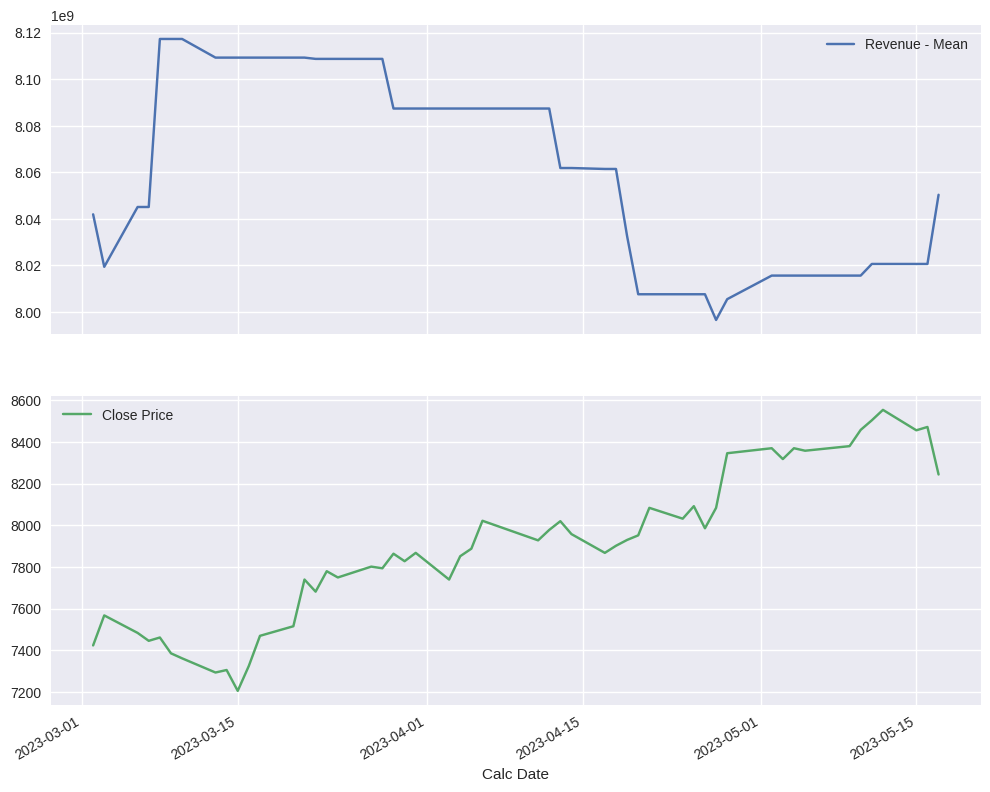

In [9]:
df6[['Revenue - Mean','Close Price']].plot(subplots=True, figsize=(12,10))

In [10]:
df6[['Revenue - Mean','Close Price']].corr()

,Revenue - Mean,Close Price
Revenue - Mean,1.000000,-0.716083
Close Price,-0.716083,1.000000


In [12]:
df7, err =ek.get_data(['LSEG.L'],['TR.RevenueMean(Period=FY1).date',
                                 'TR.RevenueSmartEst(Period=FY1)',
                                 'TR.RevenueSENumIncEst(Period=FY1)',
                                 'TR.GrossIncomeSmartEst(Period=FY1)',
                                 'TR.GrossIncomeSENumIncEst(Period=FY1)',
                                 'TR.PreTaxProfitSmartEst(Period=FY1)',
                                 'TR.PreTaxProfitSENumIncEst(Period=FY1)',
                                 'TR.NetprofitSmartEst(Period=FY1)',
                                 'TR.NetProfitSENumIncEst(Period=FY1)',
                                 'TR.EpsSmartEst(Period=FY1)',
                                 'TR.EpsSENumIncEst(Period=FY1)',
                                 'TR.DPSSmartEst(Period=FY1)',
                                 'TR.DPSSENumIncEst(Period=FY1)',
                                 'TR.CLOSEPRICE(Adjusted=1)'],
                                 {'SDate':'-200','EDate':'0'})
                      
df7.index = pd.to_datetime(df7['Date'])
df7

,Instrument,Date,Revenue - SmartEstimate®,Revenue - SmartEstimate Num of Included Estimates,Gross Income - SmartEstimate®,Gross Income - SENum Inc Ests,Pre-Tax Profit - SmartEstimate®,Pre-Tax Profit - SmartEstimate Num of Included Estimates,Net Income - SmartEstimate®,Net Income - SmarteEstimate Num of Included Estimates,Earnings Per Share - SmartEstimate®,Earnings Per Share - SmartEstimate Num of Included Estimates,Dividend Per Share - SmartEstimate®,Dividend Per Share - SmartEstimate Num of Included Estimates,Close Price
Date,,,,,,,,,,,,,,,
2022-07-22 00:00:00+00:00,LSEG.L,2022-07-22T00:00:00Z,7206623600,7,6526971940,4,2502582810,9,1685708850,12,3.021467,12,1.059146,5,7908
2022-07-29 00:00:00+00:00,LSEG.L,2022-07-29T00:00:00Z,7225313340,7,6527199560,4,2501542060,9,1681038140,12,3.014498,12,1.059185,5,7998
2022-07-29 00:00:00+00:00,LSEG.L,2022-07-29T00:00:00Z,7225313340,7,6527199560,4,2501542060,9,1681038140,12,3.014498,12,1.059185,5,7988
2022-07-29 00:00:00+00:00,LSEG.L,2022-07-29T00:00:00Z,7225313340,7,6527199560,4,2501542060,9,1681038140,12,3.014498,12,1.059185,5,8004
2022-07-29 00:00:00+00:00,LSEG.L,2022-07-29T00:00:00Z,7225313340,7,6527199560,4,2501542060,9,1681038140,12,3.014498,12,1.059185,5,8120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-11 00:00:00+00:00,LSEG.L,2023-05-11T00:00:00Z,8013687050,7,7241719440,6,2675366920,8,1890061360,12,3.426878,11,1.164116,8,8504
2023-05-11 00:00:00+00:00,LSEG.L,2023-05-11T00:00:00Z,8013687050,7,7241719440,6,2675366920,8,1890061360,12,3.426878,11,1.164116,8,8554
2023-05-11 00:00:00+00:00,LSEG.L,2023-05-11T00:00:00Z,8013687050,7,7241719440,6,2675366920,8,1890061360,12,3.426878,11,1.164116,8,8456


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

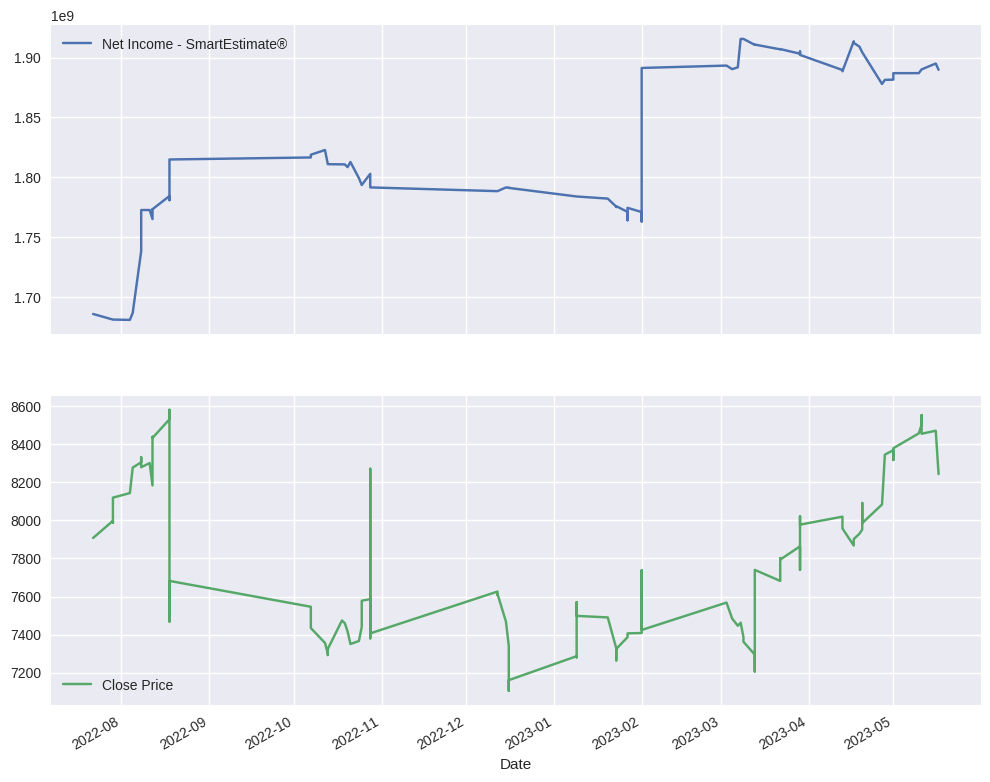

In [13]:
df7[['Net Income - SmartEstimate®','Close Price']].plot(subplots=True,figsize=(12,10))

In [15]:
df7[['Net Income - SmartEstimate®','Close Price']].corr()

,Net Income - SmartEstimate®,Close Price
Net Income - SmartEstimate®,1.00000,0.07739
Close Price,0.07739,1.00000


### Discounted Cash Flow
    
\- Many ways to approach this sort of valuation task as evidenced by number of textbooks on the subject

\- Instead of us forecasting free cash flow ourselves - we use I/B/E/S consensus - typically these go out 4 years or so 

\- After this period, forecasting becomes more challenging - but we need to capture what is known as a terminal value for the remaining cash flows based on some exit multiple

\- We take the most recent EV / FCF multiple and assign that to our last forecasted cash flow number to get our terminal value

\- So lets get some data, first some stock-type data

In [17]:
df8,err = ek.get_data('LSEG.L',['TR.F.DebtTot','TR.WACC','TR.F.ComShrOutsTot(Period=FY0)', 'TR.EVtoFCFSmartEst(Period=FY1)'])
df8

,Instrument,Debt - Total,"Weighted Average Cost of Capital, (%)",Common Shares - Outstanding - Total,EV / Free Cash Flow (SmartEstimate ®)
0,LSEG.L,8823000000,6.402185,554446680,23.271802


\- Next we will get our IBES consensus free cash flow forecasts going out 4 fiscal years. I also include the most recent actual value at the start. 

In [30]:
fcf,err = ek.get_data('LSEG.L',['TR.FCFMean(Period=FY0)','TR.FCFMean(Period=FY1)','TR.FCFMean(Period=FY2)',
                     'TR.FCFMean(Period=FY3)','TR.FCFMean(Period=FY4)'])
fcf.columns =['RIC','FCF-FY0','FCF-FY1','FCF-FY2','FCF-FY3','FCF-FY4']
fcf

,RIC,FCF-FY0,FCF-FY1,FCF-FY2,FCF-FY3,FCF-FY4
0,LSEG.L,2252871000,2286088200,2546180500,2868066750,2909460000


\- Next, calculate the net present value (NPV) of these cash flows using WACC as the discount rate.

In [31]:
dfcf = npf.npv(df8['Weighted Average Cost of Capital, (%)'][0],fcf.iloc[0,2:6].dropna(how=any).tolist())
dfcf

2689582874.2143874

\- Now calculate our terminal value using the exit multiple we identified - in this case Enterprise Value / Free Cash Flow multiple, and apply this to the last Free Cash Flow forecast (FY4).

In [32]:
tv_exit = df8['EV / Free Cash Flow (SmartEstimate ®)'][0] * fcf.iloc[0,2:5].dropna(how=any)[-1]
tv_exit

66745081088.168144

In [33]:
# We now set our flow value to be the sum of our discounted cash flow plus our terminal value. 
flo_val = dfcf + tv_exit
flo_val

# Subtract the debt portion from the enterprise value so we are left with our Equity portion
# which we can then divide by shares outstanding to get our valuation per share.

model_price = (flo_val - df8['Debt - Total'])/ df8['Common Shares - Outstanding - Total']
model_price

# As this is a UK share we need to multiply the equity value (which is in pounds) to pence 
#so we can compare it to the quoted shareprice.
model_price*100

0    10931.919362
dtype: Float64

In [34]:
df9, err = ek.get_data('LSEG.L','CF_CLOSE')
df9

,Instrument,CF_CLOSE
0,LSEG.L,8244


In [35]:
percentage_difference = ((10931.919362 - 8244) / 8244) * 100
percentage_difference

32.60455315380884

### Peer Group Comparison
    
\- Eikon Data API provide neat Peers function - retrieve list of Global Peer RICs 

\- Easy to scale an intrinsic valuation to a relative valuation or competitor analysis
    
\- We will use our previous DCF - but you can of course replace or add your own measures such as PER, PCF, PTS, EV/Ebitda, Dividend Yield etc

\- When scaling you may need to handle missing data etc so dealing with exceptions is part of process - however I just drop any problem candidates as we have enough peers
    
\- Cautionary note: no two companies are identical, differences in balance sheet structures, asset holdings, efficiencies, innovation, performance stability and many other factors all play major roles in divergent outcomes of companies. Also different economic phases can effect companies differently eg NIRP/ZIRP could keep zombie companies alive for longer than normal interest rate environments would tolerate. DCF is just one tool in our armoury.

\- Get all data we need for target and its peers -  I also drop any peers with NAs - Please enter a valid RIC in the cell below

In [89]:
ric = 'LSEG.L'

In [90]:
peers, err = ek.get_data([ric,"Peers("+ric+")"],fields=['TR.CompanyName','TR.ExchangeCountry','TR.PeersRank',
                                                    'TR.F.DebtTot','TR.WACC','TR.F.ComShrOutsTot(Period=FY0)', 
                                                    'TR.EVtoFCFSmartEst(Period=FY1)','TR.FCFMean(Period=FY0)',
                                                    'TR.FCFMean(Period=FY1)','TR.FCFMean(Period=FY2)',
                                                    'TR.FCFMean(Period=FY3)','TR.FCFMean(Period=FY4)','TR.PRICECLOSE'])
peers.columns =['RIC','Name','Country','Peers Rank','Debt - Total','WACC %','Shs Out','EV/FCF','FCF-FY0','FCF-FY1','FCF-FY2','FCF-FY3','FCF-FY4','Close Price']
peers['EV/FCF'] = peers['EV/FCF'].astype(float)
peers['Peers Rank'][0] = 0
peers.dropna(axis=0, how='any',inplace=True)
peers.reset_index(drop=True, inplace=True)
peers

,RIC,Name,Country,Peers Rank,Debt - Total,WACC %,Shs Out,EV/FCF,FCF-FY0,FCF-FY1,FCF-FY2,FCF-FY3,FCF-FY4,Close Price
0,LSEG.L,London Stock Exchange Group PLC,United Kingdom,0,8823000000,6.402185,554446680,23.271802,2252871000,2286088200,2546180500,2868066750,2909460000,8244.0
1,DB1Gn.DE,Deutsche Boerse AG,Germany,1,5357400000,4.909807,183738945,23.137660,1550771170,1832429290,1862852290,1631442430,2043231500,165.15
2,ENX.PA,Euronext NV,France,2,3094645000,5.124084,106727763,16.460273,531258830,550832290,648141000,693363330,707778500,67.2
3,SDR.L,Schroders PLC,United Kingdom,3,361000000,10.089196,1612100000,12.885429,488004330,670171670,758625000,834090330,664000000,460.1
4,AMUN.PA,Amundi SA,France,5,10453953000,6.796962,202516652,22.657146,992194330,1117415000,1255311000,1372494330,1269000000,60.85
5,DWSG.DE,DWS Group GmbH & Co KgaA,Germany,6,160000000,11.044709,200000000,9.085458,586526330,470995670,587809330,671056330,570000000,30.34
6,PGHN.S,Partners Group Holding AG,Switzerland,7,1146900000,10.921006,25909811,23.668000,1107878500,989840000,1194023750,1286613330,1530160000,824.8
7,EQTAB.ST,EQT AB,Sweden,9,2148900000,12.465953,1186127535,18.659411,657348670,1222642170,1529818670,1730029500,2161010000,202.3
8,HRGV.L,Hargreaves Lansdown PLC,United Kingdom,10,16400000,9.786652,474318625,11.707479,207794200,276954750,235356750,260885250,300426670,795.0
9,TKOO.PA,Tikehau Capital SCA,France,28,1493600000,7.226894,175193044,14.772223,305950000,353575000,406790000,583260000,163000000,24.5


\- Conduct DCF for all companies and compare closing price with model price

In [91]:
peers['m_price']= np.nan
peers['method'] = np.nan
peers['prem/disc'] = np.nan

for i, peer in enumerate(peers['RIC']):
    multiple = peers.iloc[i][7]
    
    for col in range(12,9,-1):
        if pd.isnull(peers.iloc[i][col]):
            pass
        else:
            last = col
            break
    
    dfcf = npf.npv(peers.iloc[i][5],peers.iloc[i,9:last].tolist())
    if not pd.isna(dfcf):
        if dfcf>0:
            if pd.isnull(multiple) or multiple == "NaN":
                tv_exit  =  (peers.iloc[i][last] * (1 + 0.1))  /  ((peers.iloc[i]['WACC %']) - 1)     
                peers['method'][i] = 'perpetual growth'
            elif peers.iloc[i][last] <0:
                tv_exit = multiple * peers.iloc[i,9:last].mean()
                peers['method'][i] = 'multiple - fcfAvg'
            else:
                tv_exit = multiple * peers.iloc[i][last]
                peers['method'][i] = 'multiple'
            
            flo_val = dfcf + tv_exit
            model_price = (flo_val - peers.iloc[i]['Debt - Total'])/ peers.iloc[i]['Shs Out']
            peers['m_price'][i] = model_price
            
            if peers.iloc[i][2] == 'United Kingdom' or peers.iloc[i][2] == 'South Africa':
                peers['m_price'][i] = peers['m_price'][i]*100
                
            if peers['m_price'][i] <=0:
                peers['m_price'][i] = np.nan
            
            if not pd.isnull(peers.iloc[i]['Close Price']):
                if not pd.isnull(peers.iloc[i]['m_price']):
                    peers['prem/disc'][i] = (peers.iloc[i]['Close Price'] / peers.iloc[i]['m_price']-1) *100
    else:
        peers.iloc[i]['m_price'] = np.nan

In [92]:
peers.dropna(axis=0, how='any',inplace=True)
peers.reset_index(drop=True, inplace=True)
peers

,RIC,Name,Country,Peers Rank,Debt - Total,WACC %,Shs Out,EV/FCF,FCF-FY0,FCF-FY1,FCF-FY2,FCF-FY3,FCF-FY4,Close Price,m_price,method,prem/disc
0,LSEG.L,London Stock Exchange Group PLC,United Kingdom,0,8823000000,6.402185,554446680,23.271802,2252871000,2286088200,2546180500,2868066750,2909460000,8244.0,11104.365518,multiple,-25.758928
1,DB1Gn.DE,Deutsche Boerse AG,Germany,1,5357400000,4.909807,183738945,23.137660,1550771170,1832429290,1862852290,1631442430,2043231500,165.15,240.082744,multiple,-31.211216
2,ENX.PA,Euronext NV,France,2,3094645000,5.124084,106727763,16.460273,531258830,550832290,648141000,693363330,707778500,67.2,86.488621,multiple,-22.301918
3,SDR.L,Schroders PLC,United Kingdom,3,361000000,10.089196,1612100000,12.885429,488004330,670171670,758625000,834090330,664000000,460.1,554.574207,multiple,-17.035449
4,AMUN.PA,Amundi SA,France,5,10453953000,6.796962,202516652,22.657146,992194330,1117415000,1255311000,1372494330,1269000000,60.85,96.777015,multiple,-37.123500
5,DWSG.DE,DWS Group GmbH & Co KgaA,Germany,6,160000000,11.044709,200000000,9.085458,586526330,470995670,587809330,671056330,570000000,30.34,27.715672,multiple,9.468750
6,PGHN.S,Partners Group Holding AG,Switzerland,7,1146900000,10.921006,25909811,23.668000,1107878500,989840000,1194023750,1286613330,1530160000,824.8,1395.918414,multiple,-40.913452
7,EQTAB.ST,EQT AB,Sweden,9,2148900000,12.465953,1186127535,18.659411,657348670,1222642170,1529818670,1730029500,2161010000,202.3,33.318562,multiple,507.169059
8,HRGV.L,Hargreaves Lansdown PLC,United Kingdom,10,16400000,9.786652,474318625,11.707479,207794200,276954750,235356750,260885250,300426670,795.0,801.540315,multiple,-0.815968
9,TKOO.PA,Tikehau Capital SCA,France,28,1493600000,7.226894,175193044,14.772223,305950000,353575000,406790000,583260000,163000000,24.5,7.568288,multiple,223.719175


### Relative Valuation
    
\- Now we can place VOD.L in a DCF relative valuation space amongst its peers

\- Can easily adapt to all manner of factors and metrics

\- Outlier handling important - xlim or ylim parameters useful or explicit exclusion may also be required - examples of both. If the chart has outliers try uncommenting the xlim and ylim parameters below and re-running the cell

\- Linear regression up first v

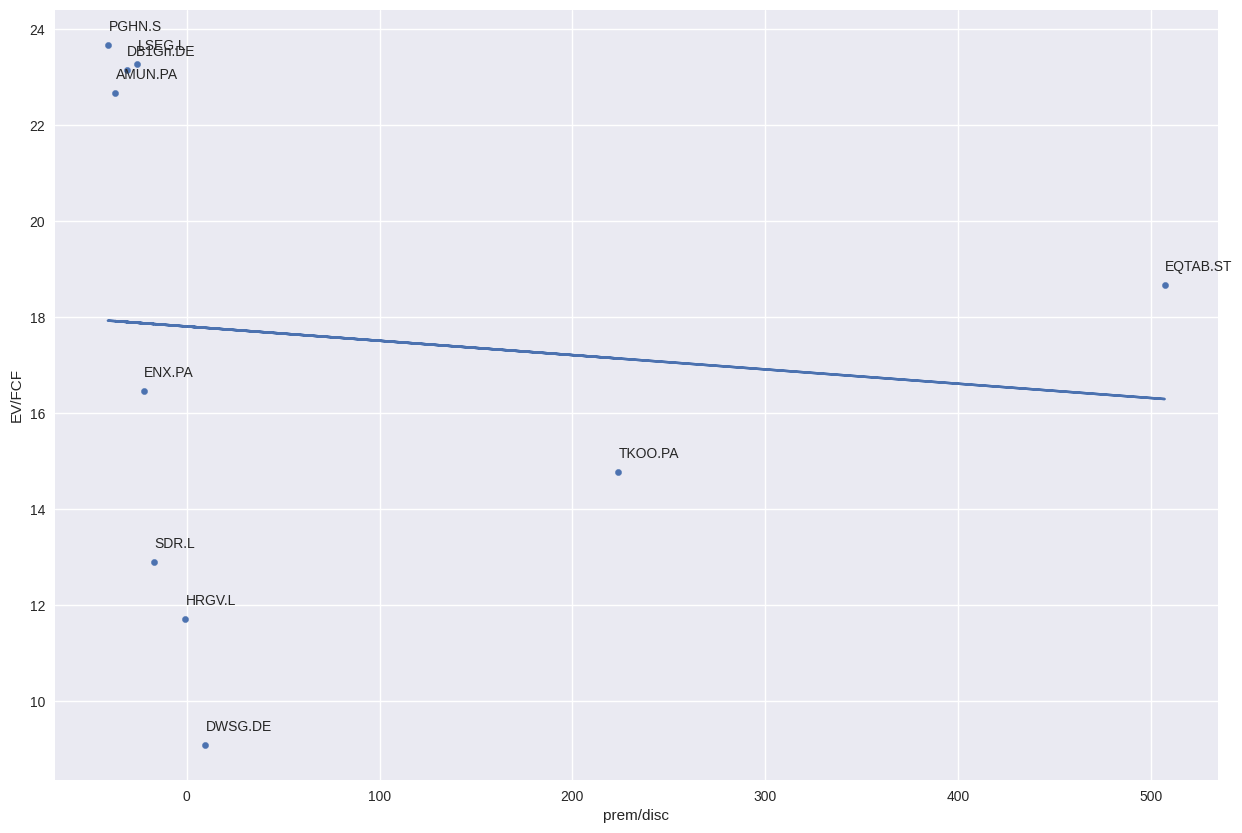

In [100]:
ax1 = peers.plot.scatter(x='prem/disc',y='EV/FCF',figsize=(15,10))

for i, ric in enumerate(peers['RIC']):
    if not pd.isnull(peers['prem/disc'][i]):
        if not pd.isnull(peers['EV/FCF'][i]):
            #ax1.set_ylim(0,100) #if you have outliers user these parameters
            #ax1.set_xlim(-100, 100) #if you have outliers user these parameter
            ax1.text(x=peers['prem/disc'][i]+0.3,y=peers['EV/FCF'][i]+0.3,s=peers['RIC'][i])

X, Y = peers['prem/disc'].values.reshape(-1,1), peers['EV/FCF'].values.reshape(-1,1)
ax1.plot(X, LinearRegression().fit(X, Y).predict(X))

## data peers evaluation 


In [79]:
import pandas as pd

ric_list = ['LSEG.L', 'MCO', 'MORN.O', 'SPGI.K', 'MSCI.K', 'VRSK.O', 'FDS']
result_list = []

for ric in ric_list:
    peers, err = ek.get_data([ric], fields=['TR.CompanyName','TR.ExchangeCountry','TR.PeersRank',
                                           'TR.F.DebtTot','TR.WACC','TR.F.ComShrOutsTot(Period=FY0)',
                                           'TR.EVtoFCFSmartEst(Period=FY1)','TR.FCFMean(Period=FY0)',
                                           'TR.FCFMean(Period=FY1)','TR.FCFMean(Period=FY2)',
                                           'TR.FCFMean(Period=FY3)','TR.FCFMean(Period=FY4)','TR.PRICECLOSE'])
    
    peers.columns = ['RIC','Name','Country','Peers Rank','Debt - Total','WACC %','Shs Out',
                     'EV/FCF','FCF-FY0','FCF-FY1','FCF-FY2','FCF-FY3','FCF-FY4','Close Price']
    
    peers['EV/FCF'] = peers['EV/FCF'].astype(float)
    peers['Peers Rank'][0] = 0
    peers.dropna(axis=0, how='any', inplace=True)
    peers.reset_index(drop=True, inplace=True)
    
    result_list.append(peers)

# Concatenate the data frames in the result_list into a single DataFrame
peers_df = pd.concat(result_list)

# Print the final DataFrame
peers_df

,RIC,Name,Country,Peers Rank,Debt - Total,WACC %,Shs Out,EV/FCF,FCF-FY0,FCF-FY1,FCF-FY2,FCF-FY3,FCF-FY4,Close Price
0,LSEG.L,London Stock Exchange Group PLC,United Kingdom,0,8823000000,6.402185,554446680,23.271802,2252871000,2286088200,2546180500,2868066750,2909460000,8244.0
0,MCO,Moody's Corp,United States of America,0,7389000000,8.711253,183199910,58.363476,1335736800,1282171820,1457055640,2472821400,2674817000,309.48
0,SPGI.K,S&P Global Inc,United States of America,0,10956000000,8.044329,329000000,30.767029,2746107780,4212084460,4988992550,5272200000,5799500000,360.94
0,MSCI.K,MSCI Inc,United States of America,0,4511946000,8.253937,79959989,36.154162,1055605500,1128198330,992453330,1380053330,1565000000,461.27
0,FDS,Factset Research Systems Inc,United States of America,0,1982424000,6.985058,38044756,29.002364,522037330,571484640,651291090,722818330,764656000,394.26


### why are morning star and verisk not working 

In [67]:
peers, err = ek.get_data(['MORN.O'],fields=['TR.CompanyName','TR.ExchangeCountry','TR.PeersRank',
                                                    'TR.F.DebtTot','TR.WACC','TR.F.ComShrOutsTot(Period=FY0)', 
                                                    'TR.EVtoFCFSmartEst(Period=FY1)','TR.FCFActValue(Period=FY0)',
                                                    'TR.FCFActValue(Period=FY1)','TR.FCFActValue(Period=FY2)',
                                                    'TR.FCFActValue(Period=FY3)','TR.FCFActValue(Period=FY4)','TR.PRICECLOSE'])
peers #'VRSK.O'

,Instrument,Company Name,Country of Exchange,Peers Rank,Debt - Total,"Weighted Average Cost of Capital, (%)",Common Shares - Outstanding - Total,EV / Free Cash Flow (SmartEstimate ®),Free Cash Flow - Actual,Free Cash Flow - Actual,Free Cash Flow - Actual,Free Cash Flow - Actual,Free Cash Flow - Actual,Price Close
0,MORN.O,Morningstar Inc,United States of America,<NA>,1109600000,8.232754,42480051,NaN,168300000,<NA>,<NA>,<NA>,<NA>,192.92


In [64]:
peers, err = ek.get_data(['VRSK.O'],fields=['TR.CompanyName','TR.ExchangeCountry','TR.PeersRank',
                                                    'TR.F.DebtTot','TR.WACC','TR.F.ComShrOutsTot(Period=FY0)', 
                                                    'TR.EVtoFCFSmartEst(Period=FY1)','TR.FCFMean(Period=FY0)',
                                                    'TR.FCFMean(Period=FY1)','TR.FCFMean(Period=FY2)',
                                                    'TR.FCFMean(Period=FY3)','TR.FCFMean(Period=FY4)','TR.PRICECLOSE'])
peers 

,Instrument,Company Name,Country of Exchange,Peers Rank,Debt - Total,"Weighted Average Cost of Capital, (%)",Common Shares - Outstanding - Total,EV / Free Cash Flow (SmartEstimate ®),Free Cash Flow - Mean,Free Cash Flow - Mean,Free Cash Flow - Mean,Free Cash Flow - Mean,Free Cash Flow - Mean,Price Close
0,VRSK.O,Verisk Analytics Inc,United States of America,<NA>,3736100000,7.161753,154701136,38.299092,832010400,883426170,957393000,<NA>,<NA>,219.12


In [83]:
import pandas as pd
import numpy as np
import numpy_financial as npf

def calculate_price(df):
    df['m_price'] = np.nan
    df['method'] = np.nan
    df['prem/disc'] = np.nan

    for i, peer in df.iterrows():
        multiple = peer[7]

        for col in range(12,9,-1):
            if pd.isnull(peer[col]):
                pass
            else:
                last = col
                break

        dfcf = npf.npv(peer[5], peer[9:last].tolist())
        if pd.notna(dfcf):
            if dfcf > 0:
                if pd.isnull(multiple) or multiple == "NaN":
                    tv_exit  =  (peer[last] * (1 + 0.1))  /  ((peer['WACC %']) - 1)     
                    df.loc[i, 'method'] = 'perpetual growth'
                elif peer[last] < 0:
                    tv_exit = multiple * peer[9:last].mean()
                    df.loc[i, 'method'] = 'multiple - fcfAvg'
                else:
                    tv_exit = multiple * peer[last]
                    df.loc[i, 'method'] = 'multiple'

                flo_val = dfcf + tv_exit
                model_price = (flo_val - peer['Debt - Total']) / peer['Shs Out']
                df.loc[i, 'm_price'] = model_price

                if peer[2] == 'United Kingdom' or peer[2] == 'South Africa':
                    df.loc[i, 'm_price'] *= 100

                if df.loc[i, 'm_price'] <= 0:
                    df.loc[i, 'm_price'] = np.nan

                if pd.notnull(peer['Close Price']):
                    if pd.notnull(df.loc[i, 'm_price']):
                        df.loc[i, 'prem/disc'] = (peer['Close Price'] / df.loc[i, 'm_price']-1) * 100
        else:
            df.loc[i, 'm_price'] = np.nan

    return df

In [85]:
peers_df = peers_df.reset_index(drop=True)
calculate_price(peers_df)
#drop the index cause it was a concat df xD 

,RIC,Name,Country,Peers Rank,Debt - Total,WACC %,Shs Out,EV/FCF,FCF-FY0,FCF-FY1,FCF-FY2,FCF-FY3,FCF-FY4,Close Price,m_price,method,prem/disc
0,LSEG.L,London Stock Exchange Group PLC,United Kingdom,0,8823000000,6.402185,554446680,23.271802,2252871000,2286088200,2546180500,2868066750,2909460000,8244.0,11104.365518,multiple,-25.758928
1,MCO,Moody's Corp,United States of America,0,7389000000,8.711253,183199910,58.363476,1335736800,1282171820,1457055640,2472821400,2674817000,309.48,819.765947,multiple,-62.247761
2,SPGI.K,S&P Global Inc,United States of America,0,10956000000,8.044329,329000000,30.767029,2746107780,4212084460,4988992550,5272200000,5799500000,360.94,523.725032,multiple,-31.082156
3,MSCI.K,MSCI Inc,United States of America,0,4511946000,8.253937,79959989,36.154162,1055605500,1128198330,992453330,1380053330,1565000000,461.27,666.844485,multiple,-30.827950
4,FDS,Factset Research Systems Inc,United States of America,0,1982424000,6.985058,38044756,29.002364,522037330,571484640,651291090,722818330,764656000,394.26,548.269848,multiple,-28.090155


In [98]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def scatter_plot(df):
    fig, ax1 = plt.subplots(figsize=(8,6))
    df.plot.scatter(x='prem/disc', y='EV/FCF', ax=ax1)

    for i, ric in df.iterrows():
        if pd.notnull(df.loc[i, 'prem/disc']) and pd.notnull(df.loc[i, 'EV/FCF']):
            ax1.text(x=df.loc[i, 'prem/disc']+0.3, y=df.loc[i, 'EV/FCF']+0.3, s=df.loc[i, 'RIC'])

    X, Y = df['prem/disc'].values.reshape(-1,1), df['EV/FCF'].values.reshape(-1,1)
    ax1.plot(X, LinearRegression().fit(X, Y).predict(X))
    plt.show()

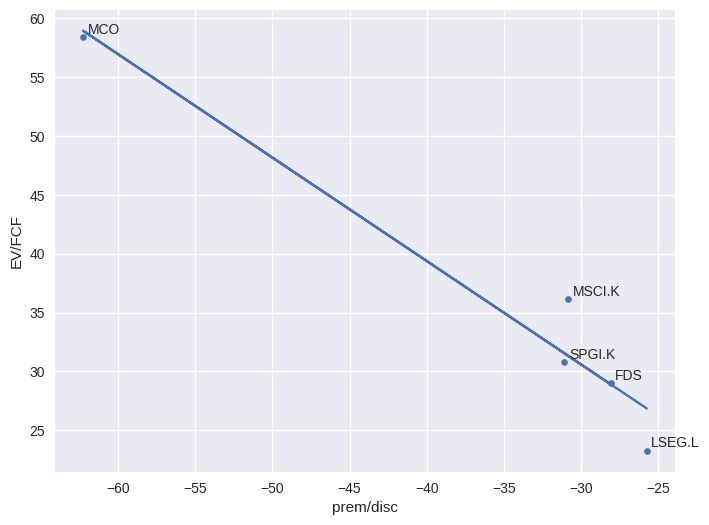

In [99]:
scatter_plot(peers_df)

## exchange peer valuation

In [102]:
import pandas as pd

# 'EEFT.O' doesnt work for some reason 

ric_list = ['LSEG.L','ICE', 'NDAQ.O', 'EEFT.O', 'CME.O', 'CBOE.K','0388.HK','DB1GnEUR.xbo' ,'MKTX.O']
result_list = []

for ric in ric_list:
    peers, err = ek.get_data([ric], fields=['TR.CompanyName','TR.ExchangeCountry','TR.PeersRank',
                                           'TR.F.DebtTot','TR.WACC','TR.F.ComShrOutsTot(Period=FY0)',
                                           'TR.EVtoFCFSmartEst(Period=FY1)','TR.FCFMean(Period=FY0)',
                                           'TR.FCFMean(Period=FY1)','TR.FCFMean(Period=FY2)',
                                           'TR.FCFMean(Period=FY3)','TR.FCFMean(Period=FY4)','TR.PRICECLOSE'])
    
    peers.columns = ['RIC','Name','Country','Peers Rank','Debt - Total','WACC %','Shs Out',
                     'EV/FCF','FCF-FY0','FCF-FY1','FCF-FY2','FCF-FY3','FCF-FY4','Close Price']
    
    peers['EV/FCF'] = peers['EV/FCF'].astype(float)
    peers['Peers Rank'][0] = 0
    peers.dropna(axis=0, how='any', inplace=True)
    peers.reset_index(drop=True, inplace=True)
    
    result_list.append(peers)

# Concatenate the data frames in the result_list into a single DataFrame
Exchpeers_df = pd.concat(result_list)

Exchpeers_df = Exchpeers_df.reset_index(drop=True)

# Print the final DataFrame
Exchpeers_df

,RIC,Name,Country,Peers Rank,Debt - Total,WACC %,Shs Out,EV/FCF,FCF-FY0,FCF-FY1,FCF-FY2,FCF-FY3,FCF-FY4,Close Price
0,LSEG.L,London Stock Exchange Group PLC,United Kingdom,0,8823000000,6.402185,554446680,23.271802,2252871000,2286088200,2546180500,2868066750,2909460000,8244.0
1,ICE,Intercontinental Exchange Inc,United States of America,0,18122000000,6.832474,559000000,23.078091,2674600000,3344333330,3632666670,3857500000,3994000000,108.6
2,NDAQ.O,Nasdaq Inc,United States of America,0,5399000000,7.282721,491592491,22.274681,1471603570,1414600000,1498600000,1526500000,1725000000,54.93
3,CME.O,CME Group Inc,United States of America,0,3514400000,5.296034,358932138,22.770770,2751400000,2658500000,2713666670,3580666670,3676000000,182.51
4,CBOE.K,Cboe Global Markets Inc,United States of America,0,1742000000,5.564767,105951199,21.053353,445000000,749000000,637250000,844000000,871000000,136.57
5,0388.HK,Hong Kong Exchanges and Clearing Ltd,Hong Kong,0,2236000000,12.75346,1267836895,9.865208,12569500000,11545516600,13368250000,18456264000,14657000000,306.0
6,DB1GnEUR.xbo,Deutsche Boerse AG,Germany,0,5357400000,4.909807,183738945,23.137660,1550771170,1832429290,1862852290,1631442430,2043231500,165.15
7,MKTX.O,Marketaxess Holdings Inc,United States of America,0,0,7.048357,37648148,35.746998,234168000,278395750,342067000,419827000,438194500,289.66


In [103]:
calculate_price(Exchpeers_df)

,RIC,Name,Country,Peers Rank,Debt - Total,WACC %,Shs Out,EV/FCF,FCF-FY0,FCF-FY1,FCF-FY2,FCF-FY3,FCF-FY4,Close Price,m_price,method,prem/disc
0,LSEG.L,London Stock Exchange Group PLC,United Kingdom,0,8823000000,6.402185,554446680,23.271802,2252871000,2286088200,2546180500,2868066750,2909460000,8244.0,11104.365518,multiple,-25.758928
1,ICE,Intercontinental Exchange Inc,United States of America,0,18122000000,6.832474,559000000,23.078091,2674600000,3344333330,3632666670,3857500000,3994000000,108.6,139.396963,multiple,-22.092994
2,NDAQ.O,Nasdaq Inc,United States of America,0,5399000000,7.282721,491592491,22.274681,1471603570,1414600000,1498600000,1526500000,1725000000,54.93,70.470170,multiple,-22.052125
3,CME.O,CME Group Inc,United States of America,0,3514400000,5.296034,358932138,22.770770,2751400000,2658500000,2713666670,3580666670,3676000000,182.51,232.274525,multiple,-21.424874
4,CBOE.K,Cboe Global Markets Inc,United States of America,0,1742000000,5.564767,105951199,21.053353,445000000,749000000,637250000,844000000,871000000,136.57,164.803475,multiple,-17.131602
5,0388.HK,Hong Kong Exchanges and Clearing Ltd,Hong Kong,0,2236000000,12.75346,1267836895,9.865208,12569500000,11545516600,13368250000,18456264000,14657000000,306.0,122.234513,multiple,150.338461
6,DB1GnEUR.xbo,Deutsche Boerse AG,Germany,0,5357400000,4.909807,183738945,23.137660,1550771170,1832429290,1862852290,1631442430,2043231500,165.15,240.082744,multiple,-31.211216
7,MKTX.O,Marketaxess Holdings Inc,United States of America,0,0,7.048357,37648148,35.746998,234168000,278395750,342067000,419827000,438194500,289.66,424.762361,multiple,-31.806575


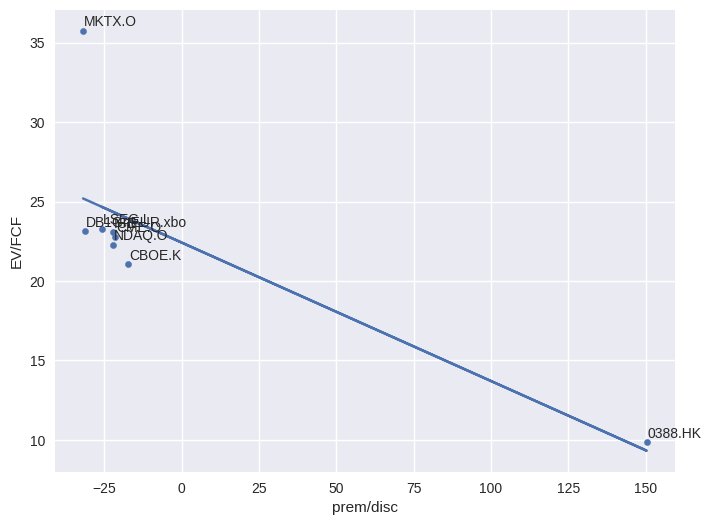

In [104]:
scatter_plot(Exchpeers_df)

## valuation all together

In [106]:
allpeers_df = pd.concat([peers_df, Exchpeers_df], ignore_index=True)
allpeers_df

,RIC,Name,Country,Peers Rank,Debt - Total,WACC %,Shs Out,EV/FCF,FCF-FY0,FCF-FY1,FCF-FY2,FCF-FY3,FCF-FY4,Close Price,m_price,method,prem/disc
0,LSEG.L,London Stock Exchange Group PLC,United Kingdom,0,8823000000,6.402185,554446680,23.271802,2252871000,2286088200,2546180500,2868066750,2909460000,8244.0,11104.365518,multiple,-25.758928
1,MCO,Moody's Corp,United States of America,0,7389000000,8.711253,183199910,58.363476,1335736800,1282171820,1457055640,2472821400,2674817000,309.48,819.765947,multiple,-62.247761
2,SPGI.K,S&P Global Inc,United States of America,0,10956000000,8.044329,329000000,30.767029,2746107780,4212084460,4988992550,5272200000,5799500000,360.94,523.725032,multiple,-31.082156
3,MSCI.K,MSCI Inc,United States of America,0,4511946000,8.253937,79959989,36.154162,1055605500,1128198330,992453330,1380053330,1565000000,461.27,666.844485,multiple,-30.827950
4,FDS,Factset Research Systems Inc,United States of America,0,1982424000,6.985058,38044756,29.002364,522037330,571484640,651291090,722818330,764656000,394.26,548.269848,multiple,-28.090155
5,LSEG.L,London Stock Exchange Group PLC,United Kingdom,0,8823000000,6.402185,554446680,23.271802,2252871000,2286088200,2546180500,2868066750,2909460000,8244.0,11104.365518,multiple,-25.758928
6,ICE,Intercontinental Exchange Inc,United States of America,0,18122000000,6.832474,559000000,23.078091,2674600000,3344333330,3632666670,3857500000,3994000000,108.6,139.396963,multiple,-22.092994
7,NDAQ.O,Nasdaq Inc,United States of America,0,5399000000,7.282721,491592491,22.274681,1471603570,1414600000,1498600000,1526500000,1725000000,54.93,70.470170,multiple,-22.052125
8,CME.O,CME Group Inc,United States of America,0,3514400000,5.296034,358932138,22.770770,2751400000,2658500000,2713666670,3580666670,3676000000,182.51,232.274525,multiple,-21.424874
9,CBOE.K,Cboe Global Markets Inc,United States of America,0,1742000000,5.564767,105951199,21.053353,445000000,749000000,637250000,844000000,871000000,136.57,164.803475,multiple,-17.131602


In [107]:
calculate_price(allpeers_df)

,RIC,Name,Country,Peers Rank,Debt - Total,WACC %,Shs Out,EV/FCF,FCF-FY0,FCF-FY1,FCF-FY2,FCF-FY3,FCF-FY4,Close Price,m_price,method,prem/disc
0,LSEG.L,London Stock Exchange Group PLC,United Kingdom,0,8823000000,6.402185,554446680,23.271802,2252871000,2286088200,2546180500,2868066750,2909460000,8244.0,11104.365518,multiple,-25.758928
1,MCO,Moody's Corp,United States of America,0,7389000000,8.711253,183199910,58.363476,1335736800,1282171820,1457055640,2472821400,2674817000,309.48,819.765947,multiple,-62.247761
2,SPGI.K,S&P Global Inc,United States of America,0,10956000000,8.044329,329000000,30.767029,2746107780,4212084460,4988992550,5272200000,5799500000,360.94,523.725032,multiple,-31.082156
3,MSCI.K,MSCI Inc,United States of America,0,4511946000,8.253937,79959989,36.154162,1055605500,1128198330,992453330,1380053330,1565000000,461.27,666.844485,multiple,-30.827950
4,FDS,Factset Research Systems Inc,United States of America,0,1982424000,6.985058,38044756,29.002364,522037330,571484640,651291090,722818330,764656000,394.26,548.269848,multiple,-28.090155
5,LSEG.L,London Stock Exchange Group PLC,United Kingdom,0,8823000000,6.402185,554446680,23.271802,2252871000,2286088200,2546180500,2868066750,2909460000,8244.0,11104.365518,multiple,-25.758928
6,ICE,Intercontinental Exchange Inc,United States of America,0,18122000000,6.832474,559000000,23.078091,2674600000,3344333330,3632666670,3857500000,3994000000,108.6,139.396963,multiple,-22.092994
7,NDAQ.O,Nasdaq Inc,United States of America,0,5399000000,7.282721,491592491,22.274681,1471603570,1414600000,1498600000,1526500000,1725000000,54.93,70.470170,multiple,-22.052125
8,CME.O,CME Group Inc,United States of America,0,3514400000,5.296034,358932138,22.770770,2751400000,2658500000,2713666670,3580666670,3676000000,182.51,232.274525,multiple,-21.424874
9,CBOE.K,Cboe Global Markets Inc,United States of America,0,1742000000,5.564767,105951199,21.053353,445000000,749000000,637250000,844000000,871000000,136.57,164.803475,multiple,-17.131602


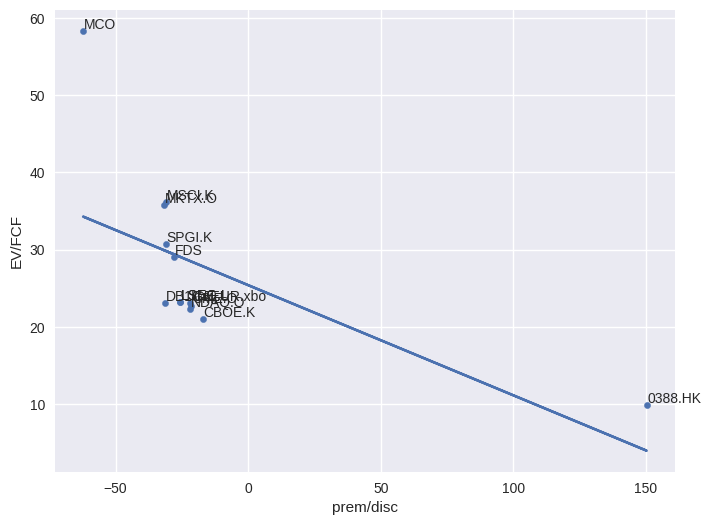

In [108]:
scatter_plot(allpeers_df)

In [117]:
def scatter_plot_3(df):
    fig, ax1 = plt.subplots(figsize=(8,6))

    for i, ric in df.iterrows():
        if pd.notnull(df.loc[i, 'prem/disc']) and pd.notnull(df.loc[i, 'EV/FCF']):
            ax1.text(x=df.loc[i, 'prem/disc']+0.3, y=df.loc[i, 'EV/FCF']+0.3, s=df.loc[i, 'RIC'])

    X, Y = df['prem/disc'].values.reshape(-1,1), df['EV/FCF'].values.reshape(-1,1)
    ax1.plot(X, LinearRegression().fit(X, Y).predict(X))

    # Plot the scatter plot after setting the x and y data
    scatter = ax1.scatter(df['prem/disc'], df['EV/FCF'], alpha=0.5, s=50)
    
    # Set the limits of x-axis
    ax1.set_xlim([-50, 20])  # Adjust the values as per your data range

    plt.show()


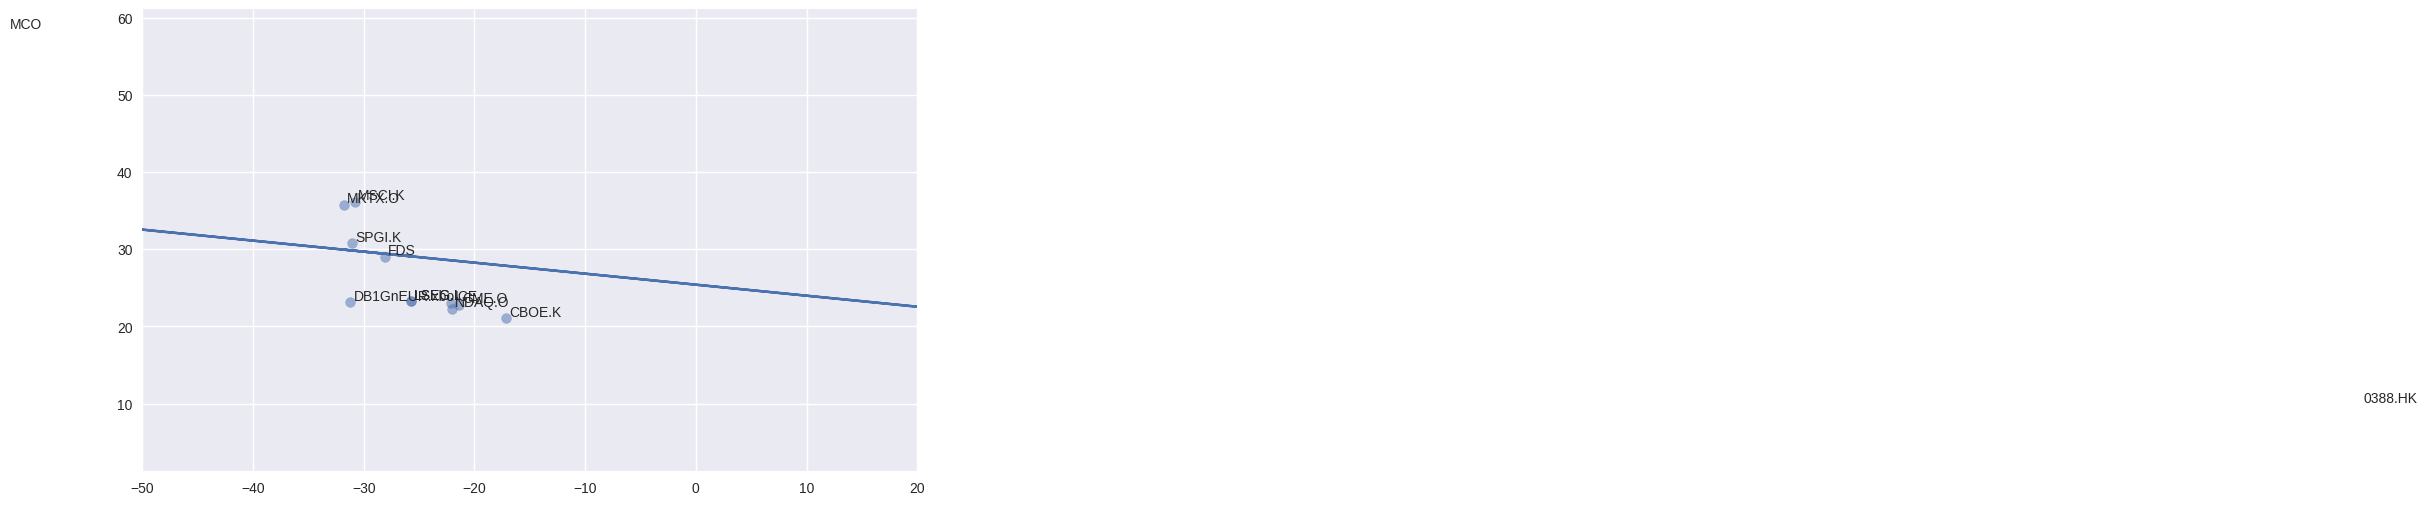

In [118]:
scatter_plot_3(allpeers_df)